$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 5: Convolutional Architecture Experiments
<a id=part5></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll use our deep CNN implementation and perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Experimenting with model architectures
<a id=part5_3></a>

We will now perform a series of experiments that train various model configurations on a part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### Note about running on GPUs

Here's an example of running a forward pass on the GPU
(assuming you're running this notebook on a GPU-enabled machine).

In [3]:
from hw2.cnn import ResNet

net = ResNet(
    in_size=(3,100,100), out_classes=10, channels=[32, 64]*3,
    pool_every=4, hidden_dims=[100]*2,
    pooling_type='avg', pooling_params=dict(kernel_size=2),
)
net = net.to(device)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_image = test_image.to(device)

test_out = net(test_image)

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [4]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are also on device={next(net.parameters()).device}')
print(f'The test image is also on device={test_image.device}')
print(f'The output is therefore also on device={test_out.device}')

This notebook is running with device=cuda
The model parameter tensors are also on device=cuda:0
The test image is also on device=cuda:0
The output is therefore also on device=cuda:0


### Notes on using course servers

First, please read the [course servers guide](https://vistalab-technion.github.io/cs236781/assignments/hpc-servers) carefully.

To run the experiments on the course servers, you can use the `py-sbatch.sh` script directly to perform a single experiment run in batch mode (since it runs python once), or use the `srun` command to do a single run in interactive mode. For example, running a single run of experiment 1 interactively (after `conda activate` of course):

```shell
srun -c 2 --gres=gpu:1 --pty python -m hw2.experiments run-exp -n test -K 32 64 -L 2 -P 2 -H 100
```

To perform multiple runs in batch mode with `sbatch` (e.g. for running all the configurations of an experiments), you can create your own script based on `py-sbatch.sh` and invoke whatever commands you need within it.

Don't request more than **2 CPU** cores and **1 GPU** device for your runs. The code won't be able to utilize more than that anyway, so you'll see no performance gain if you do. It will only cause delays for other students using the servers.

### General notes for running experiments

- You can run the experiments on a different machine (e.g. the course servers) and copy the results (files)
  to the `results` folder on your local machine.
  This notebook will only display the results, not run the actual experiment code (except for a demo run).
- It's important to give each experiment run a name as specified by the notebook instructions later on.
  Each run has a `run_name` parameter that will also be the base name of the results file which this 
  notebook will expect to load.
- You will implement the code to run the experiments in the `hw2/experiments.py` module.
  This module has a CLI parser so that you can invoke it as a script and pass in all the
  configuration parameters for a single experiment run.
- You should use `python -m hw2.experiments run-exp` to run an experiment, and **not**
  `python hw2/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1: Network depth and number of filters

In this part we will test some different architecture configurations based on our `CNN` and `ResNet`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. If we also use `pool_every=3`, the feature-extraction part of our model will be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->Conv(32,64)->ReLU->MaxPool->Conv(64,64)->ReLU
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pool_every` and `hidden_dims`. Note that you should select the `pool_every` parameter wisely per experiment so that you don't end up with zero-width feature maps.

You can try some short manual runs to determine some good values for the hyperparameters or implement cross-validation to do it. However, the **dataset size** you test on should be large. If you limit the number of batches, make sure to use at least 30000 training images and 5000 validation images.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `cnn_experiment()` function in the `hw2/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

Files already downloaded and verified


Files already downloaded and verified


--- EPOCH 1/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/10 [00:00<?, ?it/s]

test_batch:   0%|          | 0/10 [00:00<?, ?it/s]

*** Output file ./results/test_run_L1_K32-64.json written
experiment config:  {'run_name': 'test_run', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'filters_per_layer': [32, 64], 'layers_per_block': 1, 'pool_every': 1, 'hidden_dims': [100], 'model_type': 'resnet', 'kw': {}}


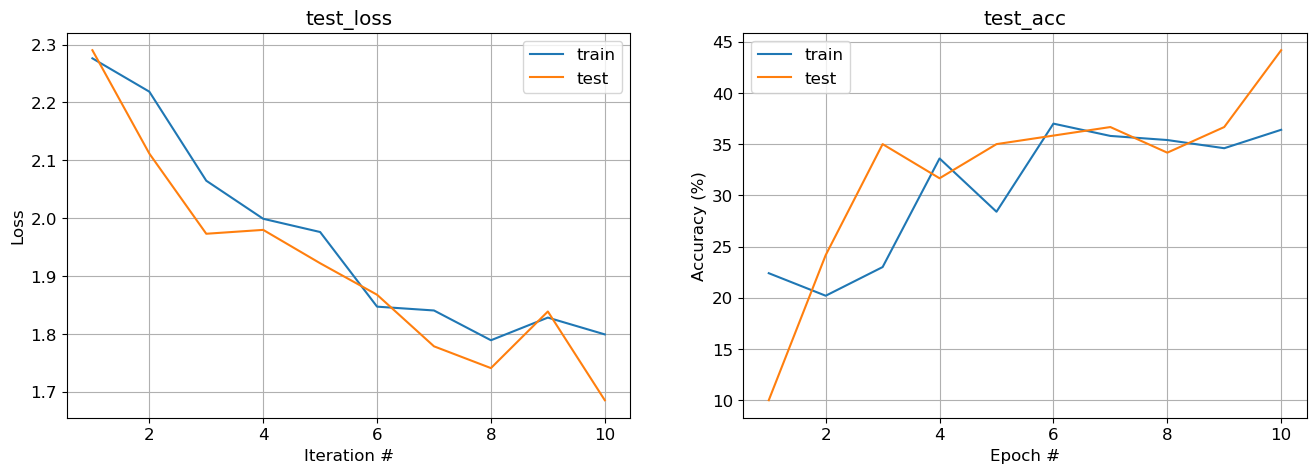

In [5]:
from hw2.experiments import load_experiment, cnn_experiment
from cs236781.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
cnn_experiment(
    'test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
    filters_per_layer=[32,64], layers_per_block=1, pool_every=1, hidden_dims=[100],
    model_type='resnet',
)

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run_L1_K32-64.json')
_, _ = plot_fit(fit_res, train_test_overlay=True)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)

We'll use the following function to load multiple experiment results and plot them together.

In [6]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


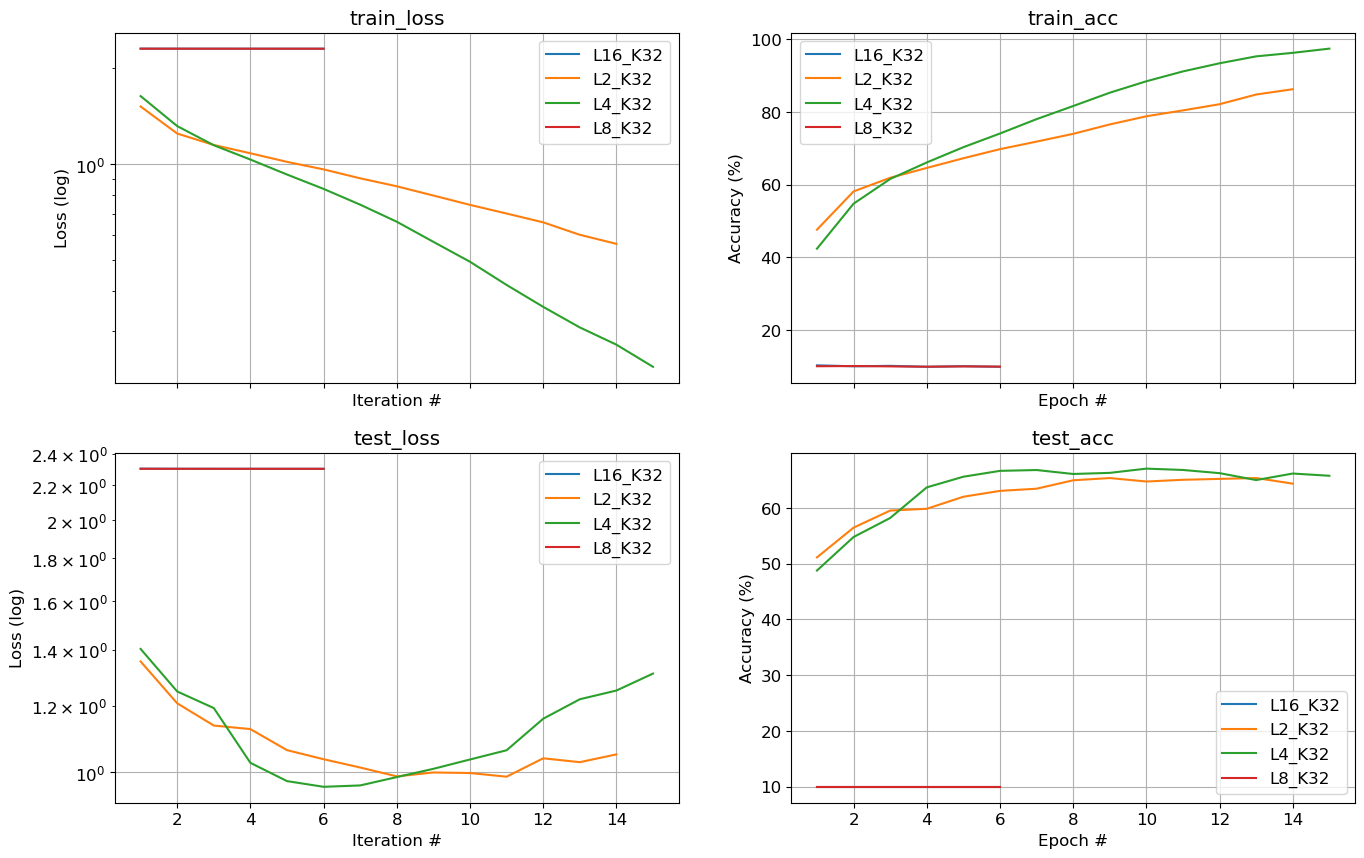

In [7]:
plot_exp_results('exp1_1_L*_K32*.json')

common config:  {'run_name': 'exp1_1', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


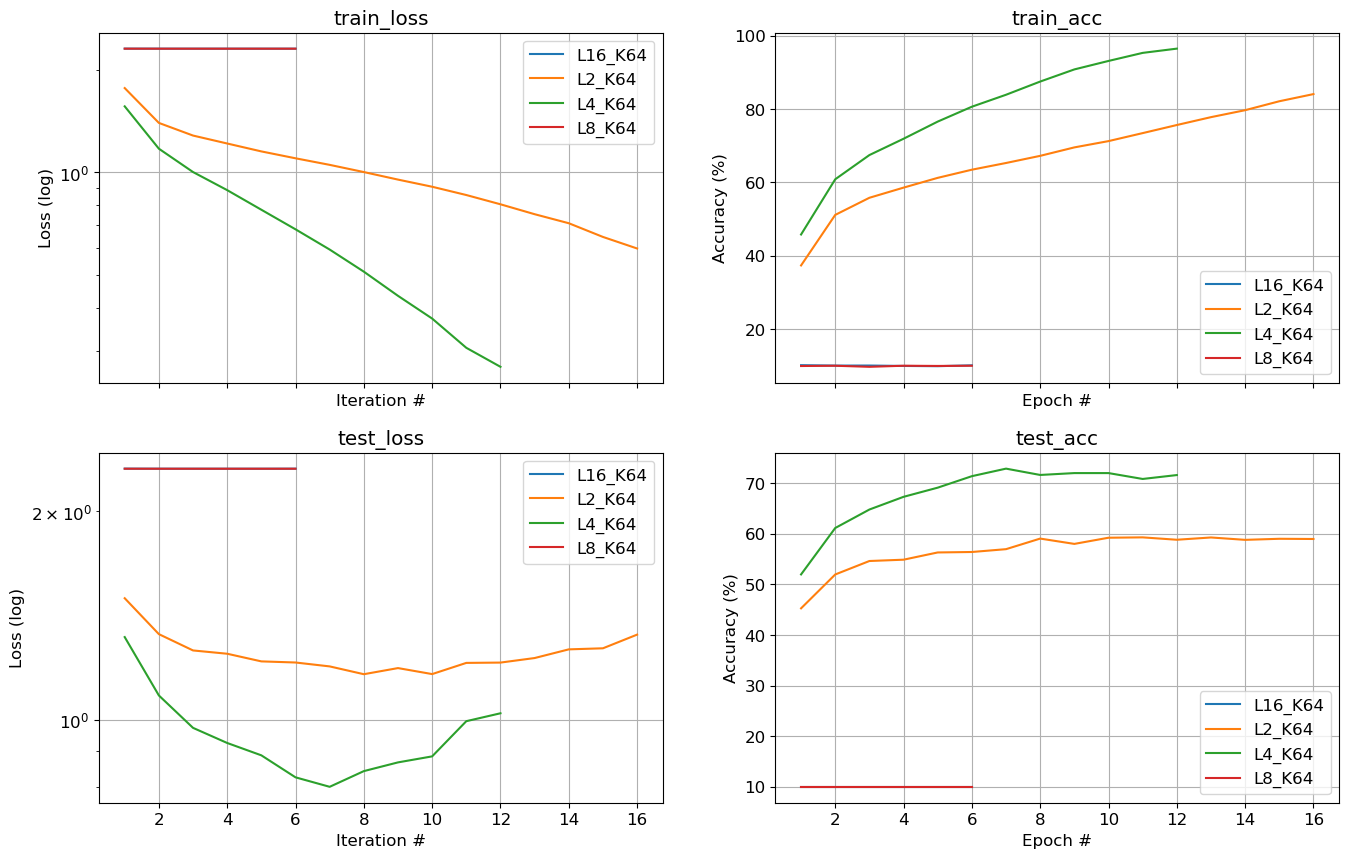

In [8]:
plot_exp_results('exp1_1_L*_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


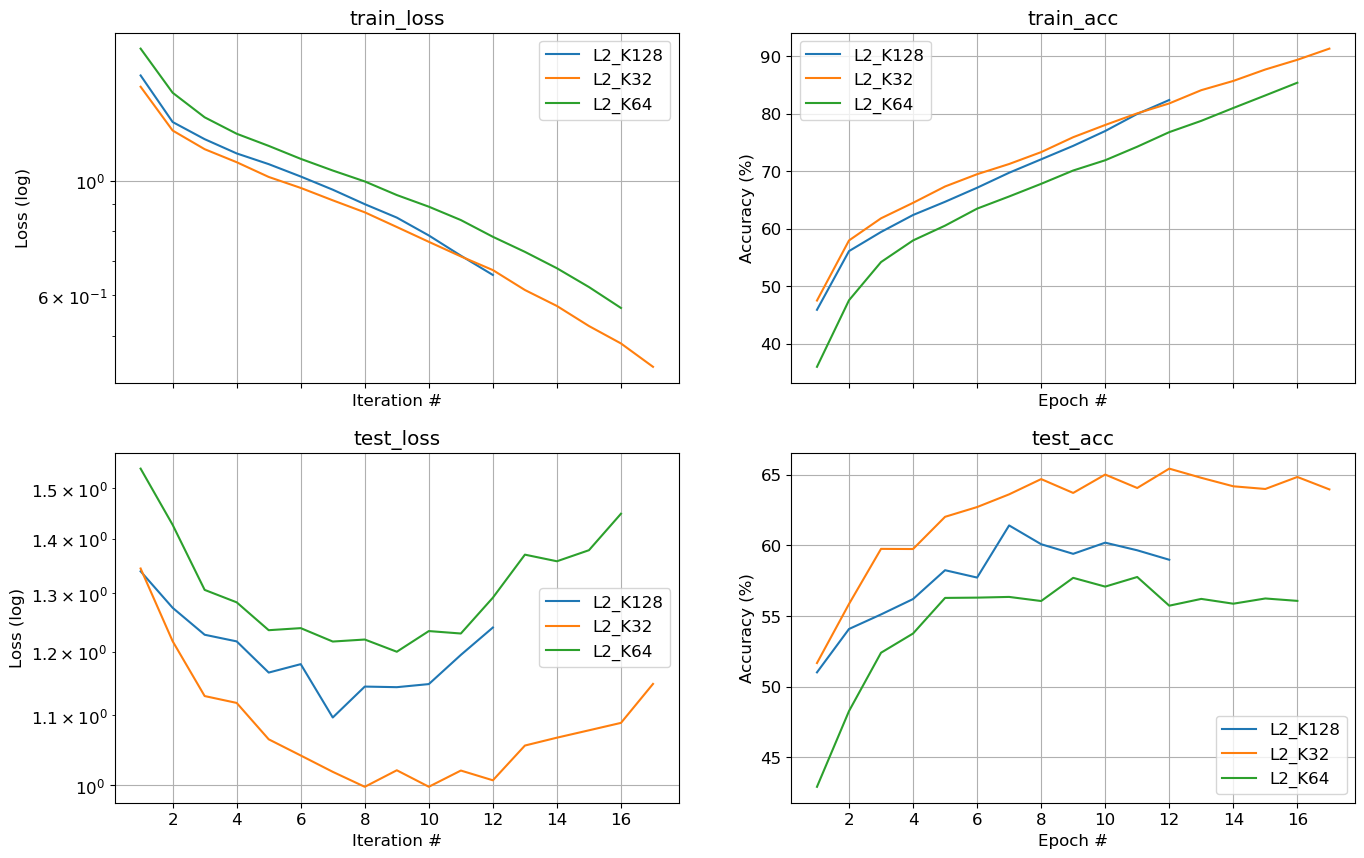

In [9]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


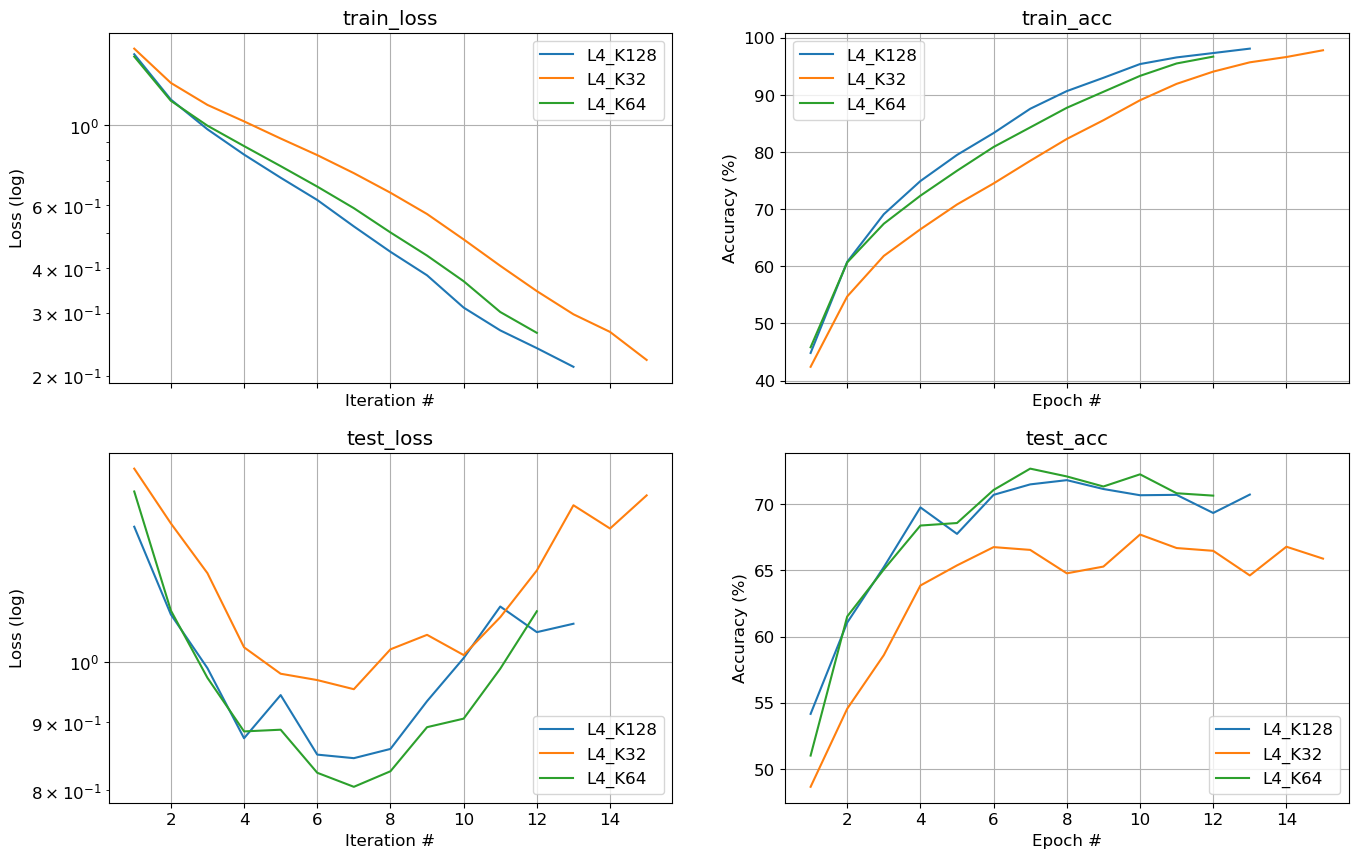

In [10]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


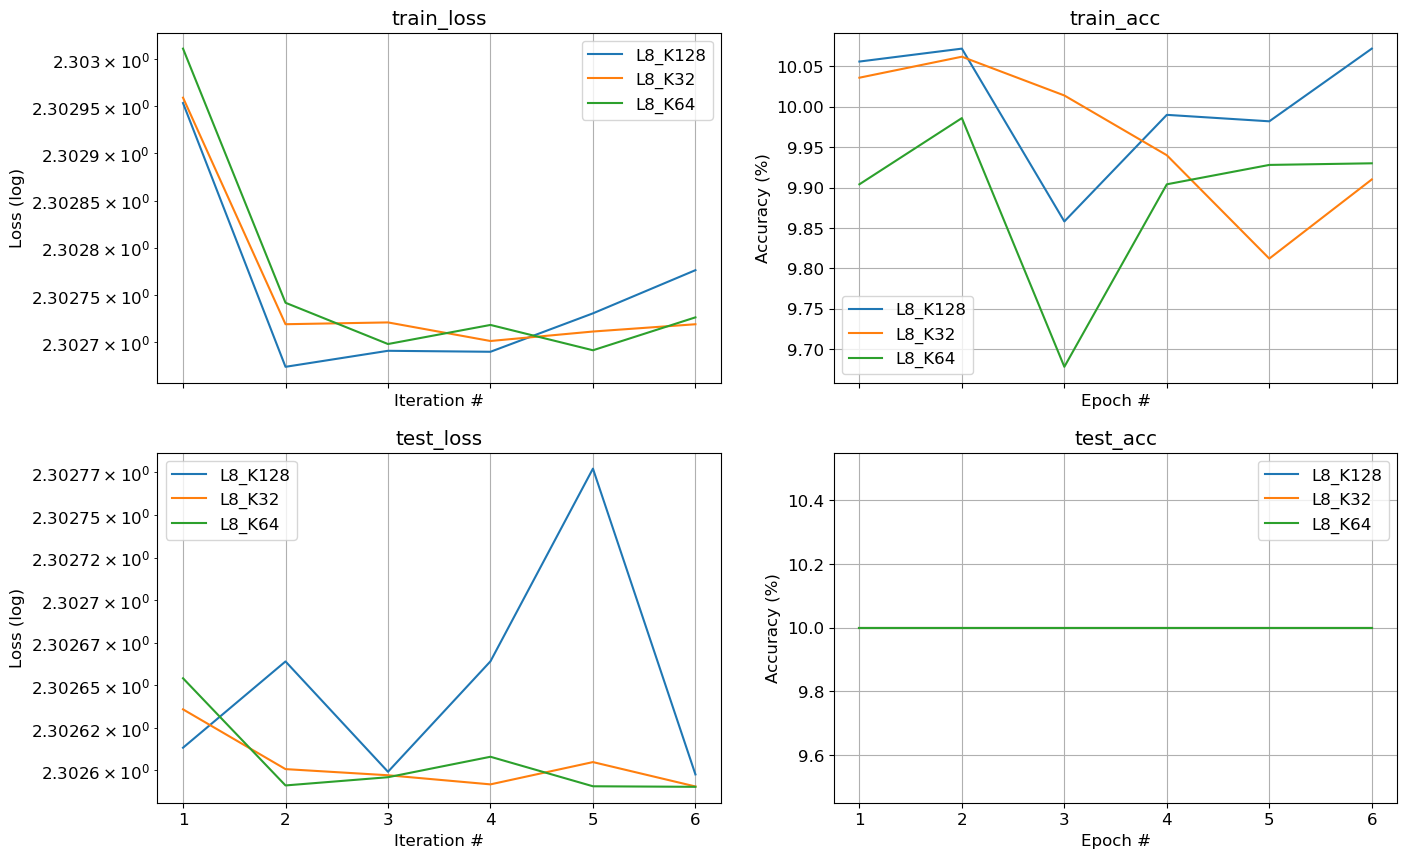

In [11]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128]` fixed with `L=2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L2_K64-128-256`. 

**TODO**: Run the experiment on the above configuration  with the `CNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'cnn', 'kw': {}}


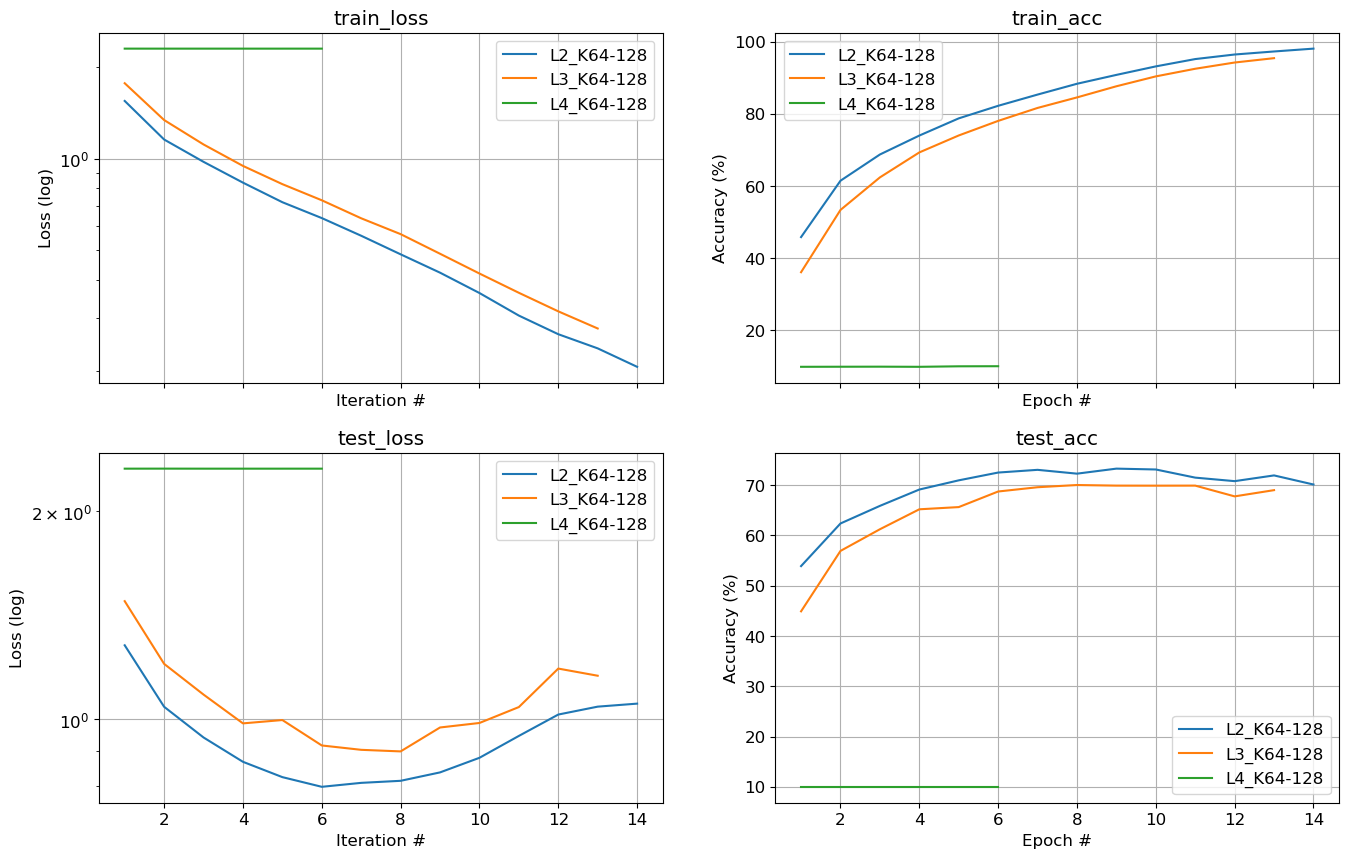

In [12]:
plot_exp_results('exp1_3*.json')

#### Experiment 1.4: Adding depth with Residual Networks

Now we'll test the effect of skip connections on the training and performance.

**Configuratons**:
- `K=[32]` fixed with `L=8,16,32` varying per run.
- `K=[64, 128, 256]` fixed with `L=2,4,8` varying per run.

So 6 different runs in total.

**Naming runs**:
Each run should be named `exp1_4_L{}_K{}-{}-{}` where the braces are placeholders for the values.

**TODO**: Run the experiment on the above configuration with the `ResNet` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [512], 'model_type': 'resnet', 'kw': {}}


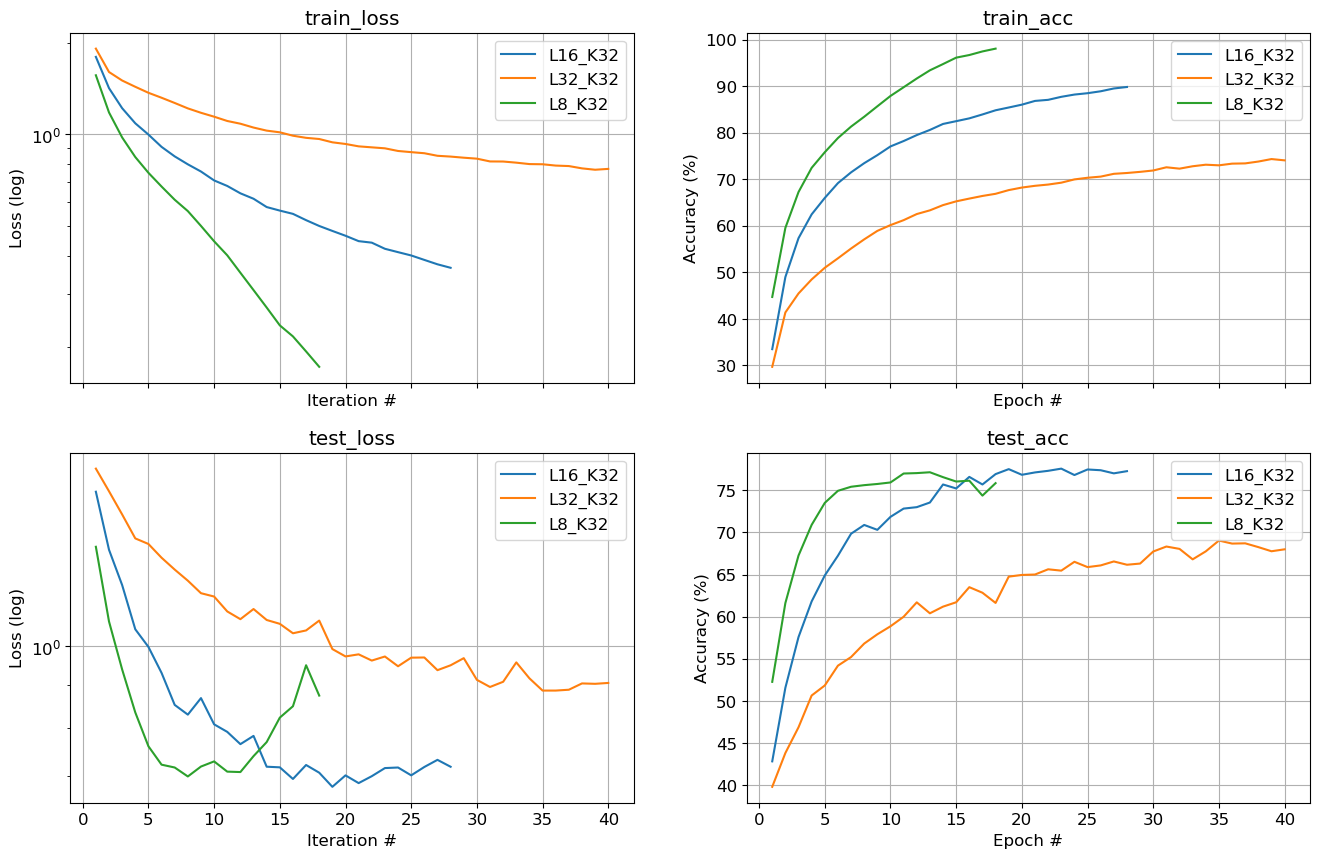

In [13]:
plot_exp_results('exp1_4_L*_K32.json')

common config:  {'run_name': 'exp1_4', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 500, 'epochs': 50, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 6, 'hidden_dims': [512], 'model_type': 'resnet', 'kw': {}}


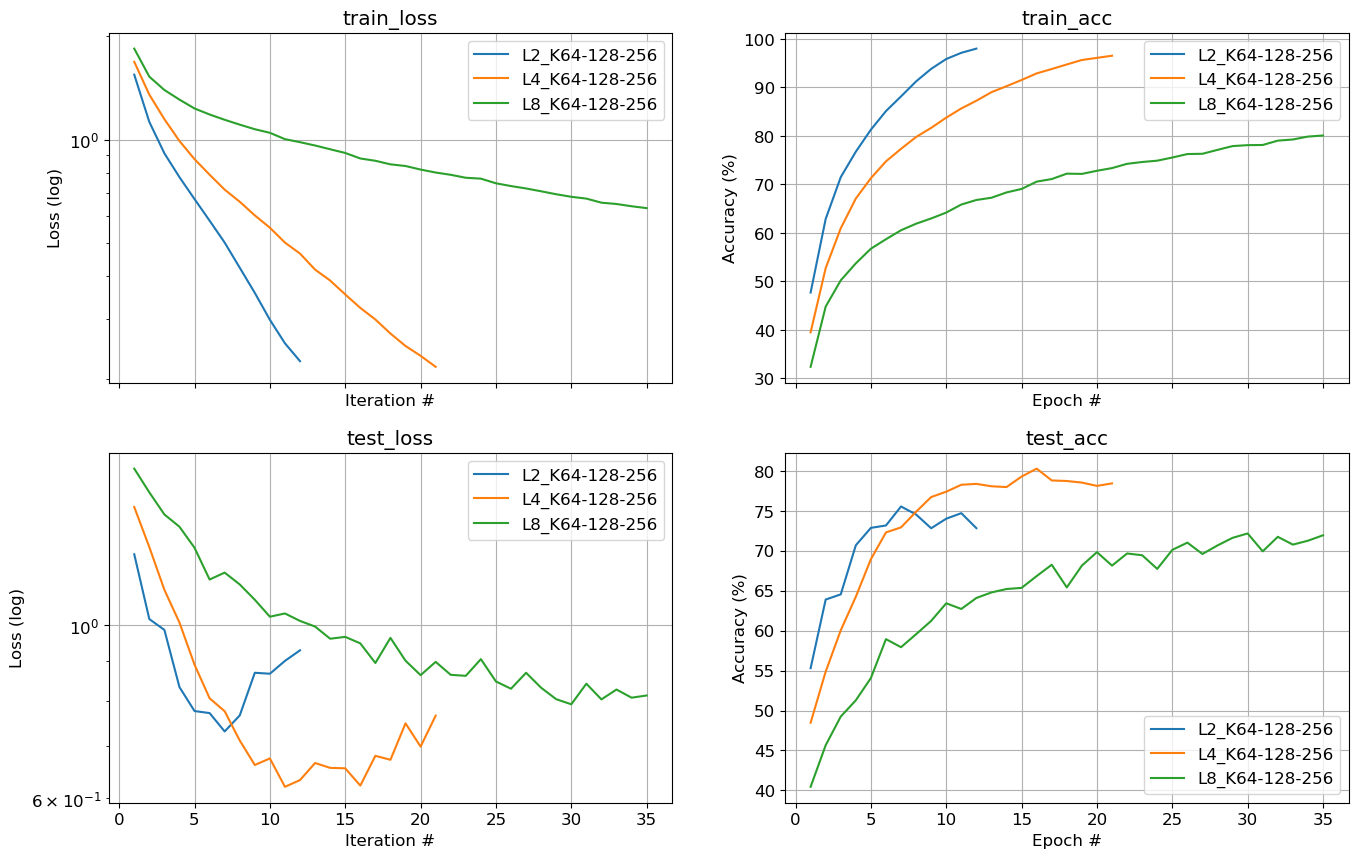

In [14]:
plot_exp_results('exp1_4_L*_K64*.json')

In this part you will create your own custom network architecture based on the `CNN` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections, bottlenecks
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures (e.g. inception module)

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCNN` class within the `hw2/cnn.py` module.

In [15]:
from hw2.cnn import YourCNN

net = YourCNN((3,100,100), 10, channels=[32]*4, pool_every=2, hidden_dims=[100]*2)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).unsqueeze(0)
test_out = net(test_image)
print('out =', test_out)

YourCNN(
  (feature_extractor): Sequential(
    (0): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0.2, inplace=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (shortcut_path): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): ResidualBlock(
      (main_path): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Dropout2d(p=0.2, inplace=False)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(32, 32, ker

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[32, 64, 128]` fixed with `L=3,6,9,12` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

If you want, you can add some extra runs following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L3_K32-64-128`. 

**TODO**: Run the experiment on the above configuration with the `YourCNN` model. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp2', 'out_dir': './results', 'seed': 42, 'device': None, 'bs_train': 128, 'bs_test': 32, 'batches': 400, 'epochs': 30, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 9, 'hidden_dims': [256], 'model_type': 'yours', 'kw': {}}


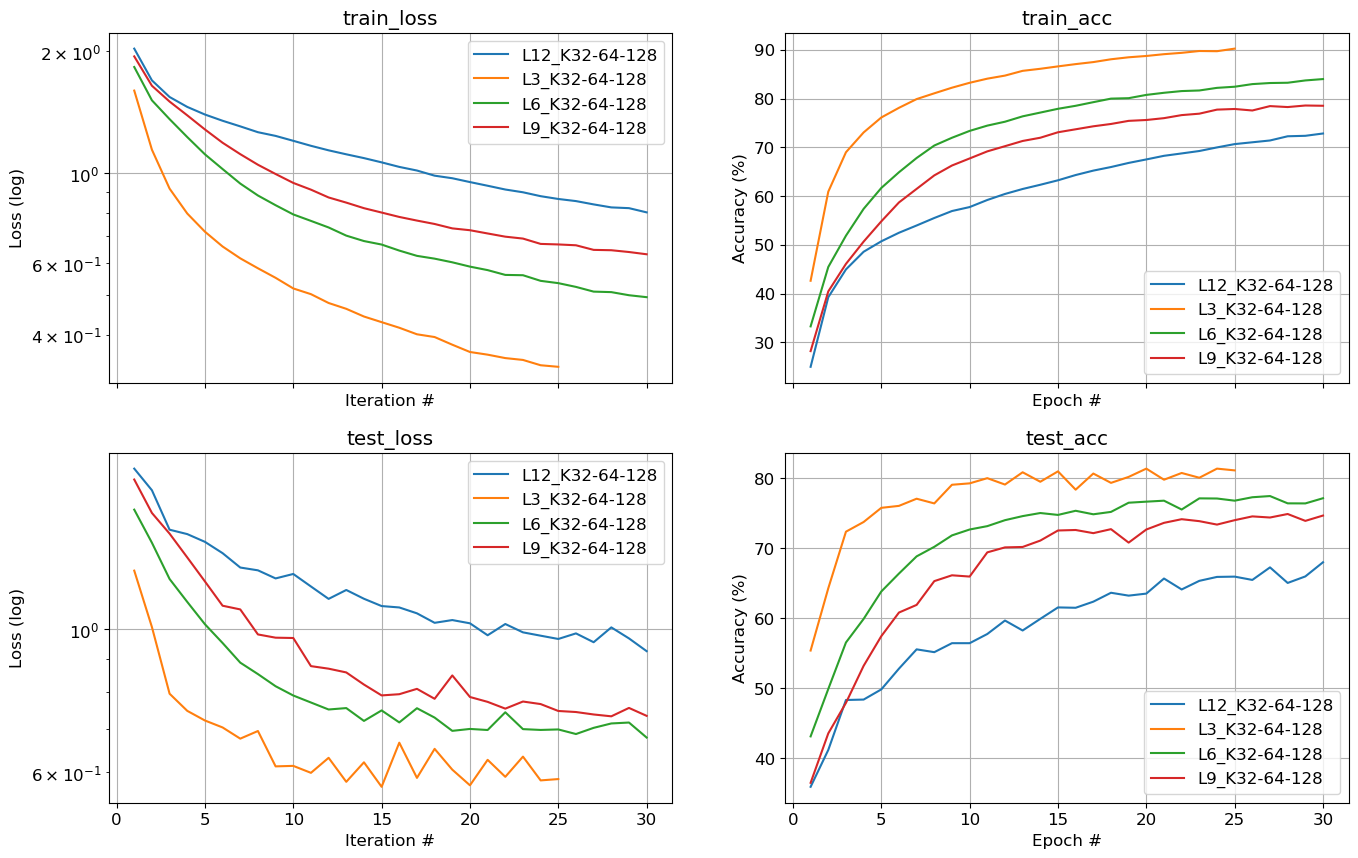

In [16]:
plot_exp_results('exp2*.json')

## Questions
<a id=part5_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [17]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [18]:
display_answer(hw2.answers.part5_q1)


### 1. Analysis of the Effect of Depth ($L$)
In this experiment, we observed that increasing the depth of a **plain** CNN (without skip connections) does not linearly improve performance.

* **Optimal Depth:** Typically, the best results are achieved with value of $L=4$. At these depth, the network has enough capacity to learn meaningful hierarchical features from the CIFAR-10 dataset while remaining shallow enough for the gradient to flow effectively from the output back to the input layers.
* **Performance Degradation:** As $L$ increases to 8 and 16, the network's accuracy begins to drop. Even though a deeper model has more parameters and theoretically higher representational capacity, the difficulty of optimizing a deep "plain" stack outweighs the benefits of the added layers.

### 2. Non-trainable values of $L$ and the Vanishing Gradient
We observed that for higher values of $L$ (specifically $L=8$ and $L=16$), the network often became **untrainable**. This was characterized by flat-line accuracy (near 10%) and loss curves that did not decrease, eventually triggering **early stopping**.

**The Cause: Vanishing Gradients**
In a plain CNN, the gradient is computed using the chain rule. During backpropagation, the error signal is multiplied by the weights and the derivatives of the activation functions at every layer. 
If intermediate derivatives are small (which is common with standard initialization), multiplying them 8 or 16 times causes the gradient to decay exponentially until it vanishes. The early layers receive no update, so the model never learns to extract basic features.

**Suggested Resolutions:**
1.  **Residual Connections (Skip Connections):** Introduce "shortcuts" that allow the gradient to bypass layers. By changing the layer to $y = F(x) + x$, the gradient can flow through the identity path ($+1$ in the derivative), ensuring it stays strong even at $L=16$.
    
2.  **Batch Normalization:** Adding Batchnorm layers after convolutions helps keep the activations in a range where the derivatives (e.g., of a ReLU or Tanh) are less likely to vanish or saturate, stabilizing the distribution of inputs to deeper layers and allowing for higher learning rates.


### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [19]:
display_answer(hw2.answers.part5_q2)



### Analysis of Experiment 1.2: Filter Width ($K$) vs. Depth ($L$)

#### 1. Case $L=2$:
* The network is shallow enough to converge across all tested filter widths $K$, but we observe that **smaller filter counts ($K=32$) generalize better in this configuration.
* **U-Shape Loss:** The test loss exhibits a distinct **U-shape**, reaching a minimum before rising. This indicates that as training continues, the added complexity of 64 or 128 filters introduces more parameters than the architecture can effectively regularize, causing the model to move past the point of optimal generalization.
* **Overfitting:** Significant overfitting is evident as training accuracy approaches $90\%$ while test accuracy plateaus much lower, creating a visible generalization gap.

#### 2. Case $L=4$:
At $L=4$, the relationship between width and performance flips; the network now requires more filters to reach its peak potential, though overfitting becomes even more pronounced.
* $K=64$ and $K=128$ outperformed $K=32$ in test accuracy.
* With 4 layers, the model has enough architectural depth to benefit from a higher number of features ($K=64, 128$). However, without regularization, the model uses its increased capacity to memorize the training set rather than generalizing.
* **U-Shape Loss:** A very sharp **U-shape** is visible in the test loss for all $K$ values. The loss drops quickly but rebounds aggressively after approximately iteration 7. This confirms that higher capacity leads to faster divergence once the training set is memorized.
* **Overfitting:** We observe extreme overfitting across all values of $K$. For $K=128$, training accuracy reaches nearly $100\%$, yet test accuracy remains around $70\%$, resulting in a massive generalization gap.

#### 3. Case $L=8$:
* All configurations ($K=32, 64, 128$) remained stuck at $\approx 10\%$ accuracy.
* This confirms that **width is irrelevant when depth creates an optimization barrier.** In a plain CNN architecture without skip connections or normalization, the vanishing gradient problem prevents any learning from occurring at $L=8$, rendering the number of filters $K$ moot.

### Comparison to Experiment 1.1
Comparing these results to Experiment 1.1 highlights how width and depth interact:
1. **Depth is the primary constraint:** Just as in Experiment 1.1, increasing depth beyond a certain point ($L=8$) leads to total failure that no amount of width ($K$) can fix.
2. Experiment 1.2 shows that the "best" $K$ depends on depth—$K=32$ was best for $L=2$, but $K=64$ was required to maximize the potential of $L=4$.
3. While Experiment 1.1 focused on the depth-limit, Experiment 1.2 shows that even at stable depths, adding width ($K=128$) or depth ($L=4$) accelerates overfitting, leading to high training accuracy but stagnant or degrading test performance due to the lack of regularization.


### Question 3 

Analyze your results from experiment 1.3.

In [20]:
display_answer(hw2.answers.part5_q3)



### Analysis of Experiment 1.3: Multi-Stage Filter Width ($K=[64, 128]$) vs. Depth ($L$)

#### 1. Case $L=2$ and $L=3$:
Both the $L=2$ and $L=3$ configurations successfully converged, as the network depth was shallow enough for the gradient to propagate effectively despite the increased width.
* Both models achieved high performance, with $L=2$ performing slightly better, peaking at approximately $73-74\%$ test accuracy, while $L=3$ reached approximately $69-70\%$.
* Both configurations exhibit significant overfitting, characterized by a large gap between training accuracy (approaching $100\%$) and test accuracy.
* A clear **U-shape** is visible in the test loss for both runs; the loss reaches a minimum before rebounding upward.
* This confirms that as the model exhausts its ability to generalize, it uses its high filter capacity to memorize the training set, causing the test performance to degrade. While $L=3$ provides more parameters, the optimization difficulty of the extra layer results in slightly lower accuracy than the $L=2$ baseline.

#### 2. Case $L=4$:
At $L=4$, the multi-stage architecture suffers a total training failure, highlighting the critical trade-off between filter width and network depth.
* Both training and test accuracy flatline at exactly $10\%$, and the training loss remains stagnant near $2.30$.
* This result demonstrates that **increasing the width incrementally ($64 \to 128$) cannot compensate for excessive depth** in a plain CNN architecture.
* Even though $L=4$ was trainable with narrower filters in previous runs, the added complexity of wider filters at this depth triggers an earlier optimization collapse. The gradients fail to propagate through the (K*L)=8-layer wide stack.



### Question 4

Analyze your results from experiment 1.4. Compare to experiment 1.1 and 1.3.

In [21]:
display_answer(hw2.answers.part5_q4)



### Analysis of Experiment 1.4: The Impact of Skip Connections

In this experiment, we introduced skip connections (Residual connections) to resolve the optimization bottlenecks identified in previous experiments. These results clearly demonstrate that skip connections are the primary driver for training deeper networks effectively.

The most significant result is the successful training of deep architectures that previously suffered from total optimization collapse in Experiments 1.1 and 1.3.
* **Overcoming Vanishing Gradients:** Unlike plain CNNs, where $L \ge 8$ resulted in stagnant $10\%$ accuracy, the Residual networks with $L=8, 16, \text{and } 32$ converged successfully.
* **Identity Mapping:** Skip connections allow the gradient to bypass weight layers through the identity path $H(x) = F(x) + x$. This ensures that the error signal remains strong enough to update early layers even at extreme depths like $L=32$.

#### 1. Case $K=32$ ($L=8, 16, 32$):
* **The Benefit of Depth:** With skip connections, we see that $L=16$ (blue) achieves high test accuracy ($\approx 77\%$), outperforming the best results from Experiment 1.1.
* **Diminishing Returns:** Interestingly, the $L=32$ model (orange) performs worse than $L=16$, plateauing around $68\%$ test accuracy. This suggests that while skip connections solve trainability, very deep plain-residual stacks may still struggle with generalization or require additional stabilization like Batch Normalization to leverage their full capacity.

#### 2. Case $K=[64, 128, 256]$ ($L=2, 4, 8$):
This wide, multi-stage architecture achieved the best performance across all experiments.
* The $L=4$ variant reached a peak test accuracy of $\approx 80\%$, proving that combining skip connections with increased width ($K$) provides the most robust architecture for CIFAR-10.
* For $L=2$ and $L=4$, we observe a very sharp **U-shape** in the test loss. Because these models reach near $100\%$ training accuracy quickly, they begin to memorize the dataset, causing test loss to rebound aggressively after the initial drop.

### Comparison to Previous Experiments

1. **Comparison to Experiment 1.1:** In Experiment 1.1, depth was a liability beyond $L=4$. In Experiment 1.4, depth becomes an asset up to $L=16$, thanks to the stabilization provided by skip connections.
2. **Comparison to Experiment 1.3:** Experiment 1.3 showed that increasing width made deep networks even more fragile, with failure occurring at $L=4$. In contrast, the Residual version of the wide architecture ($L=8, K=[64, 128, 256]$) trains perfectly and outperforms all plain models.
3. **Generalization Gap:** Across all successful runs, the generalization gap remains the biggest challenge. While skip connections solved the **trainability wall**, the models still require early stopping or better regularization to manage the memorization of training noise.


In [22]:
display_answer(hw2.answers.part5_q5)



### Question 5: Architecture Analysis of YourCNN and Experiment 2

#### 1. Architectural Enhancements in YourCNN
To improve training stability and performance relative to the initial "plain" CNN models, we introduced several key architectural changes in the `YourCNN` class:

* **Residual (Skip) Connections:** We utilized the `ResidualBlock` to implement skip connections ($H(x) = F(x) + x$). This allows gradients to bypass the weight layers through an identity path, fundamentally solving the vanishing gradient problem and allowing us to train deeper stacks that previously failed.
* **Integrated Batch Normalization:** We enabled `batchnorm=True` within each block to normalize feature map statistics. This stabilizes the distribution of inputs to deeper layers, prevents activation drifting, and allows for more robust optimization.
* **Strategic Dropout (0.2):** We applied a dropout rate of $0.2$ to provide regularization without starving the deep layers of signal. While higher dropout (0.5) was initially tested, the $0.2$ rate provided the necessary balance to prevent neuron co-adaptation while maintaining information flow in deep architectures.
* **Leaky ReLU Activation:** We replaced standard ReLU with Leaky ReLU (slope=$0.01$). This ensures a small gradient flow for negative inputs, mitigating the "dying ReLU" problem and preserving signal during the backward pass.



#### 2. Analysis of Experiment 2 Results
We evaluated this architecture using fixed pyramidal filters ($K=[32, 64, 128]$) across varying depths $L=3, 6, 9, 12$.

* **Successful Convergence at Extreme Depths:** The introduction of residual connections and BatchNorm allowed all configurations to train effectively. Unlike previous experiments where $L=8$ or $L=12$ failed, these models show consistently decreasing training loss and increasing accuracy.
* **Performance Peak at $L=3$:** The shallowest configuration ($L=3$, orange) achieved the highest overall performance, peaking at over $80\%$ test accuracy. As depth increased, we observed a steady decline in test performance, with $L=12$ (blue) reaching approximately $68\%$.
* **Generalization and Overfitting:** All models reached high training accuracy (between $72\%$ and $90\%$), but the gap between training and test accuracy widened with depth. The test loss converge after 17-20 epochs from that point test accuracy the same, but the traning accuracy improved which indicate start of overfitting.



#### 3. Comparison to Experiment 1.4 (Residual CNNs)
The `YourCNN` architecture is very similar to the Residual CNNs tested in Experiment 1.4, as both rely on skip connections to enable deep learning. However, this experiment places a stronger emphasis on **generalization** through the following improvements:

* **Improved Baseline:** The $L=3$ configuration in `YourCNN` reached $\approx 81\%$ test accuracy, outperforming the best $K=32$ results from Experiment 1.4 ($\approx 78\%$). This improvement is largely attributed to the addition of **Dropout**, **Batch Normalization** and **Leaky ReLU**, which provide better generalization and internal stability than the basic residual structure alone.
* **Balanced Regularization:** By making the dropout rate to $0.2$, `YourCNN` maintains a more consistent signal than the models in Experiment 1.4.
* Experiment 1.4 proved that skip connections fix **trainability**, but `YourCNN` demonstrates that combining them with Dropout, BatchNorm and Leaky ReLU is necessary to improve **generalization** on the test set. 
